# Using a custom sampler so that harder classes are over-sampled in data

In [1]:
experiment_name = 'weighted_sampler'

# Install and import

In [2]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter

In [3]:
%matplotlib inline
from tqdm import trange
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
import pytorch_metric_learning.utils.logging_presets as logging_presets
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning
import os
from torchvision.datasets.folder import default_loader
import datetime
import seaborn as sns

logging.getLogger().setLevel(logging.INFO)

In [4]:
%load_ext tensorboard

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
from src import params
from src.dataset import (get_transforms, get_cub_2011, get_cub_2011_class_disjoint, get_inverse_transform)
from src.models import (get_embedder, get_trunk)
from src.training import (get_optimizers, get_loss, get_miner, get_sampler, get_testing_hooks)
from src.utils import get_experiment_id, git_version
from src.evaluation import get_inference_model, get_scores, get_embeddings

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
print("Git commit hash", git_version())

Git commit hash 45f3e23fdcbd877eb727c9ed42745be7a06436b0


# Experiment parameters

In [10]:
params.get_params()

{'embedder_layers': [512, 256],
 'batch_size': 32,
 'num_epochs': 40,
 'test_interval': 5,
 'patience': 2}

# Prepare for training

## Dataset

In [11]:
train_transform, val_transform = get_transforms()

In [12]:
original_train, original_val = get_cub_2011()

In [13]:
train_dataset, val_dataset = get_cub_2011_class_disjoint(train_transform, val_transform)

## Model

In [14]:
trunk, trunk_output_size = get_trunk(device)

embedder = get_embedder(trunk_output_size, params.embedder_layers, device)

## Optimizers

In [15]:
trunk_optimizer, embedder_optimizer = get_optimizers(trunk, embedder)

## Custom sampler

In [16]:
from torch.utils.data.sampler import Sampler
from pytorch_metric_learning.utils import common_functions as c_f

class ClassWeightedSampler(Sampler):
    """
    At every iteration, this will return m samples per class, weighted by the weights array.
    """
    def __init__(self, labels, m, min_per_class=2, max_per_class=6, weights=None, length_before_new_iter=100000):
        if isinstance(labels, torch.Tensor):
            labels = labels.numpy()
        self.m = int(m)
        self.min_per_class = int(min_per_class) 
        self.max_per_class = int(max_per_class) 
        
        self.labels_to_indices = c_f.get_labels_to_indices(labels)
        self.labels = list(self.labels_to_indices.keys())
        if weights is None:
            weights = [1/len(self.labels)]*len(self.labels)
        
        self.weights = np.array(weights)
        
        self.label_to_weight_idx = {label: i for label, i in zip(self.labels, range(len(weights)))}
        
        assert len(self.labels) == len(self.weights)
        
        self.length_of_single_pass = self.m*len(self.labels)
        #print(self.m, print(len(self.labels)))
        self.list_size = length_before_new_iter
        if self.length_of_single_pass < self.list_size:
            self.list_size -= (self.list_size) % (self.length_of_single_pass)
        #print('list size', self.list_size)
            
    @property
    def m_per_class(self):
#         print(self.m)
#         print(self.list_size)
#         print(self.weights)
        return np.clip((self.length_of_single_pass*self.weights).astype(int), a_min=self.min_per_class, a_max=self.max_per_class)
    
    def __len__(self):
        return self.list_size

    def __iter__(self):
        idx_list = []
        #print('len idx list', len(idx_list))
        i = 0
        num_iters = self.list_size // self.length_of_single_pass if self.length_of_single_pass < self.list_size else 1
        #print('Num iters', num_iters)
        self.shuffled_labels = list(self.labels)
        for _ in range(num_iters):
            c_f.NUMPY_RANDOM.shuffle(self.shuffled_labels)
            for label in self.shuffled_labels:
                t = self.labels_to_indices[label]
                label_idx = self.label_to_weight_idx[label]
                m_per_label = self.m_per_class[label_idx]
                #print('M per label', self.m_per_class)
                #print('label', label)
                #print("label idx", label_idx)
                #print('idx list before', len(idx_list), idx_list)
                idx_list += list(c_f.safe_random_choice(t, size=m_per_label))
                #print('idx list after', len(idx_list), idx_list)
                i += m_per_label
            #print('iter over')
        print('Idx list len', len(idx_list))
        #print('Returning iterator over idx list', idx_list)
        return iter(idx_list)

In [17]:
# labels = np.array([0, 0, 0, 1, 1, 2, 2, 2])

# # Equal weights
# sampler = ClassWeightedSampler(labels, 2, weights=[2/6, 2/6, 2/6], length_before_new_iter=len(labels))
# sample = labels[[i for i in sampler]]
# print(sample)
# assert (sorted(sample) == sorted([1, 1, 0, 0, 2, 2]))

# # One oversampled
# sampler = ClassWeightedSampler(labels, 2, weights=[1/6, 1/6, 4/6], length_before_new_iter=len(labels))
# sample = labels[[i for i in sampler]]
# print(sample)
# assert (sorted(sample) == sorted([1, 0, 2, 2, 2, 2]))

# # One excluded (actually not excluded)
# sampler = ClassWeightedSampler(labels, 2, weights=[0, 2/6, 4/6], length_before_new_iter=len(labels))
# sample = labels[[i for i in sampler]]
# print(sample)
# assert (sorted(sample) == sorted([0, 1, 1, 2, 2, 2, 2]))

# # One different indices each time
# sampler = ClassWeightedSampler(labels, 2, weights=[0, 2/6, 4/6], length_before_new_iter=len(labels))
# indices1 = [i for i in sampler]
# indices2 = [i for i in sampler]
# print(indices1, indices2)
# assert indices1 != indices2

# # Lots of data
# labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])
# sampler = ClassWeightedSampler(labels, 2, weights=[1/6, 1/6, 4/6], length_before_new_iter=len(labels))
# sample = labels[[i for i in sampler]]
# assert len(sample) == len(labels)

## Loss, miner, sampler


In [18]:
train_dataset.targets, val_dataset.targets

(array([ 1,  1,  1, ..., 99, 99, 99]),
 array([100, 100, 100, ..., 200, 200, 200]))

In [19]:
loss = get_loss()
miner = get_miner()
sampler = ClassWeightedSampler(train_dataset.targets, m=4, length_before_new_iter=len(train_dataset))

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

optimizers, loss_funcs, mining_funcs

({'trunk_optimizer': Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 1e-05
      weight_decay: 0.0001
  ),
  'embedder_optimizer': Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0.0001
  )},
 {'metric_loss': TripletMarginLoss(
    (reducer): AvgNonZeroReducer()
  )},
 {'tuple_miner': TripletMarginMiner()})

# Train the model

In [20]:
%tensorboard --logdir "experiment_logs/tensorboard"

Reusing TensorBoard on port 6006 (pid 33810), started 1:25:07 ago. (Use '!kill 33810' to kill it.)

In [21]:
experiment_id = get_experiment_id(experiment_name)
experiment_dir = os.path.join('experiment_logs', experiment_id)

In [22]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [23]:
from sklearn.metrics import f1_score
from pytorch_metric_learning.utils import stat_utils
from pytorch_metric_learning.utils.accuracy_calculator import get_lone_query_labels, get_label_counts

class CustomTester(testers.GlobalEmbeddingSpaceTester):
    def do_knn_and_accuracies(self, accuracies, embeddings_and_labels, split_name):
        super().do_knn_and_accuracies(accuracies, embeddings_and_labels, split_name)
        if split_name == 'train':
            #print('Computing per-class f1-scores')
            query_embeddings, query_labels, reference_embeddings, reference_labels = self.set_reference_and_query(embeddings_and_labels, split_name)
        
            for L in self.label_levels:
                curr_query_labels = query_labels[:, L]
                curr_reference_labels = reference_labels[:, L]
                label_counts, num_k = get_label_counts(curr_reference_labels)
                embeddings_come_from_same_source =  self.embeddings_come_from_same_source(embeddings_and_labels)
                knn_indices, knn_distances = stat_utils.get_knn(reference_embeddings, query_embeddings, num_k, embeddings_come_from_same_source)
                knn_labels = curr_reference_labels[knn_indices]

                lone_query_labels = get_lone_query_labels(curr_query_labels, curr_reference_labels, label_counts, embeddings_come_from_same_source)
                not_lone_query_mask = ~np.isin(curr_query_labels, lone_query_labels)
                if not any(not_lone_query_mask):
                    print("Warning: None of the query labels are in the reference set and I barely know what that means.")
                
#                 print(curr_reference_labels)
#                 print(knn_labels[:, :1].flatten())
#                 print(sampler.labels)
                
                def normalize(v):
                    return v / np.sum(v)
            
                f1_scores = f1_score(curr_reference_labels, knn_labels[:, :1].flatten(), labels=sampler.labels, average=None)
                #print('f1 scores per class', f1_scores)
                new_weights = normalize(softmax(f1_scores))
                print('Sampler weights are now', new_weights)
                sampler.weights = new_weights
                
                plt.figure(figsize=(10, 7))
                sns.barplot(x=sampler.labels, 
                            y=sampler.m_per_class)
                plt.title('Sampler m per class')
                plt.show()
            
            
                break
            
def get_testing_hooks(experiment_id, val_dataset, test_interval, patience):
    experiment_dir = os.path.join('experiment_logs', experiment_id)
    record_keeper, _, _ = logging_presets.get_record_keeper(experiment_dir, os.path.join('experiment_logs', 'tensorboard', experiment_id))
    hooks = logging_presets.get_hook_container(record_keeper)
    dataset_dict = {"val": val_dataset, 'train': train_dataset}
    model_folder = experiment_dir

    def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
        logging.info("UMAP plot for the {} split and label set {}".format(split_name, keyname))
        label_set = np.unique(labels)
        num_classes = len(label_set)
        fig = plt.figure(figsize=(20,15))
        plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
        for i in range(num_classes):
            idx = labels == label_set[i]
            plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)   
        plt.show()
        
        writer = SummaryWriter(log_dir=os.path.join('experiment_logs', 'tensorboard', experiment_id))
        writer.add_embedding(umap_embeddings, metadata=labels)
        writer.close()

    # Create the tester
    tester = CustomTester(end_of_testing_hook = hooks.end_of_testing_hook, 
                                                visualizer = umap.UMAP(), 
                                                visualizer_hook = visualizer_hook,
                                                dataloader_num_workers = 6)
    end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                                dataset_dict, 
                                                model_folder, 
                                                test_interval = test_interval,
                                                patience = patience)
    return end_of_epoch_hook, hooks.end_of_iteration_hook

# Params override

In [24]:
params.test_interval = 2
params.patience = 3

INFO:root:Initializing dataloader
INFO:root:Initializing dataloader iterator
INFO:root:Done creating dataloader iterator
INFO:root:TRAINING EPOCH 1
  0%|          | 0/173 [00:00<?, ?it/s]

Idx list len 5544


/home/boris/.local/lib/python3.8/site-packages/pytorch_metric_learning/utils/loss_and_miner_utils.py:127: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  a_idx = triplets.nonzero()[:, 0].flatten()
total_loss=0.10456: 100%|██████████| 173/173 [00:20<00:00,  8.33it/s]
INFO:root:TRAINING EPOCH 2
  0%|          | 0/173 [00:00<?, ?it/s]

Idx list len 5544


total_loss=0.11905: 100%|██████████| 173/173 [00:22<00:00,  7.86it/s]
INFO:root:Evaluating epoch 2
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 18.64it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.21it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


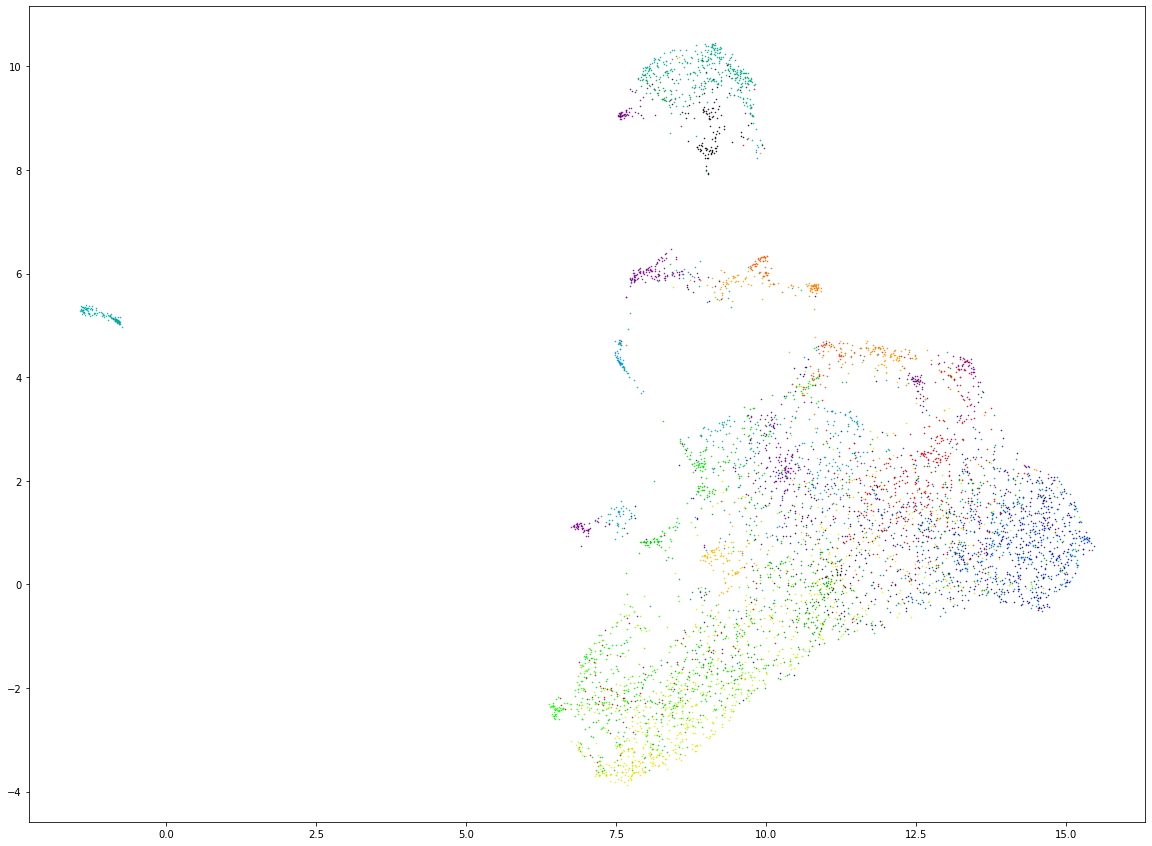

INFO:root:Running UMAP on the train set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


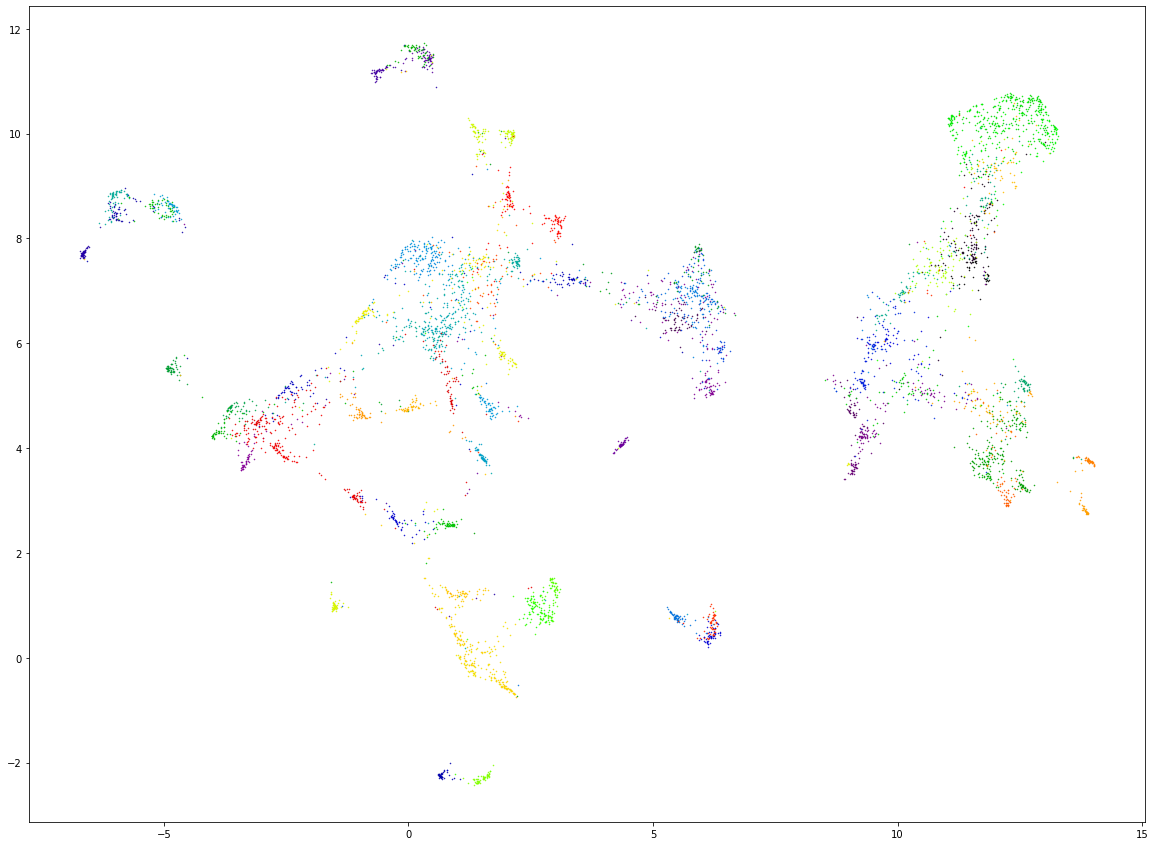

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


Sampler weights are now [0.010015   0.00938044 0.00818582 0.0104119  0.01131831 0.0131491
 0.01196799 0.00970568 0.00638316 0.01178527 0.00717568 0.01316384
 0.01177017 0.01073395 0.01250679 0.01213137 0.01114565 0.01235049
 0.00996324 0.00982972 0.01200897 0.01105581 0.00875864 0.00970568
 0.00784278 0.00976424 0.00682806 0.01324837 0.00752412 0.00662093
 0.00941435 0.00866507 0.00861737 0.0122794  0.0105873  0.01310497
 0.00762507 0.00708583 0.00717236 0.00748327 0.01114565 0.01213865
 0.00750499 0.01022763 0.00838697 0.01079048 0.01159107 0.01342998
 0.00717443 0.00854243 0.00901026 0.01103404 0.01157563 0.00911123
 0.01101454 0.00908682 0.01300805 0.00947453 0.00619639 0.00607374
 0.01114741 0.00620337 0.01181816 0.00741618 0.00750499 0.007703
 0.0089805  0.00890343 0.01102521 0.01348516 0.00705278 0.00771288
 0.01196799 0.01077416 0.01339011 0.01171648 0.01157853 0.0088661
 0.00954625 0.01014678 0.01247224 0.00924986 0.01208727 0.00990804
 0.01261258 0.00934724 0.01267179 0.012764

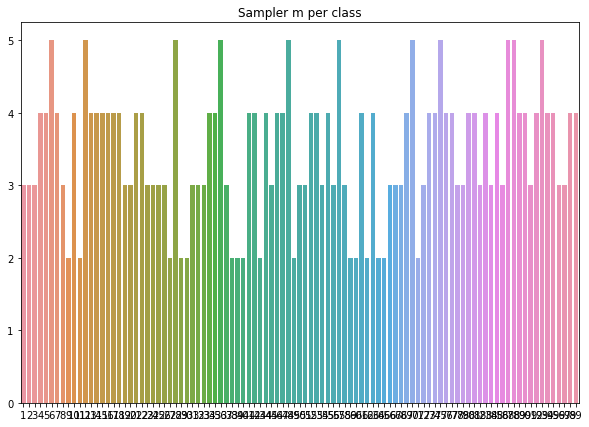

INFO:root:New best accuracy! 0.10283252657061931
INFO:root:TRAINING EPOCH 3
  0%|          | 0/173 [00:00<?, ?it/s]

Idx list len 4802


total_loss=0.12523:  87%|████████▋ | 150/173 [00:19<00:02,  7.81it/s]

Idx list len 4802


total_loss=0.07998: 100%|██████████| 173/173 [00:23<00:00,  7.50it/s]
INFO:root:TRAINING EPOCH 4
total_loss=0.10132:  73%|███████▎  | 127/173 [00:16<00:05,  7.99it/s]

Idx list len 4802


total_loss=0.09612: 100%|██████████| 173/173 [00:22<00:00,  7.58it/s]
INFO:root:Evaluating epoch 4
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 18.50it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.39it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


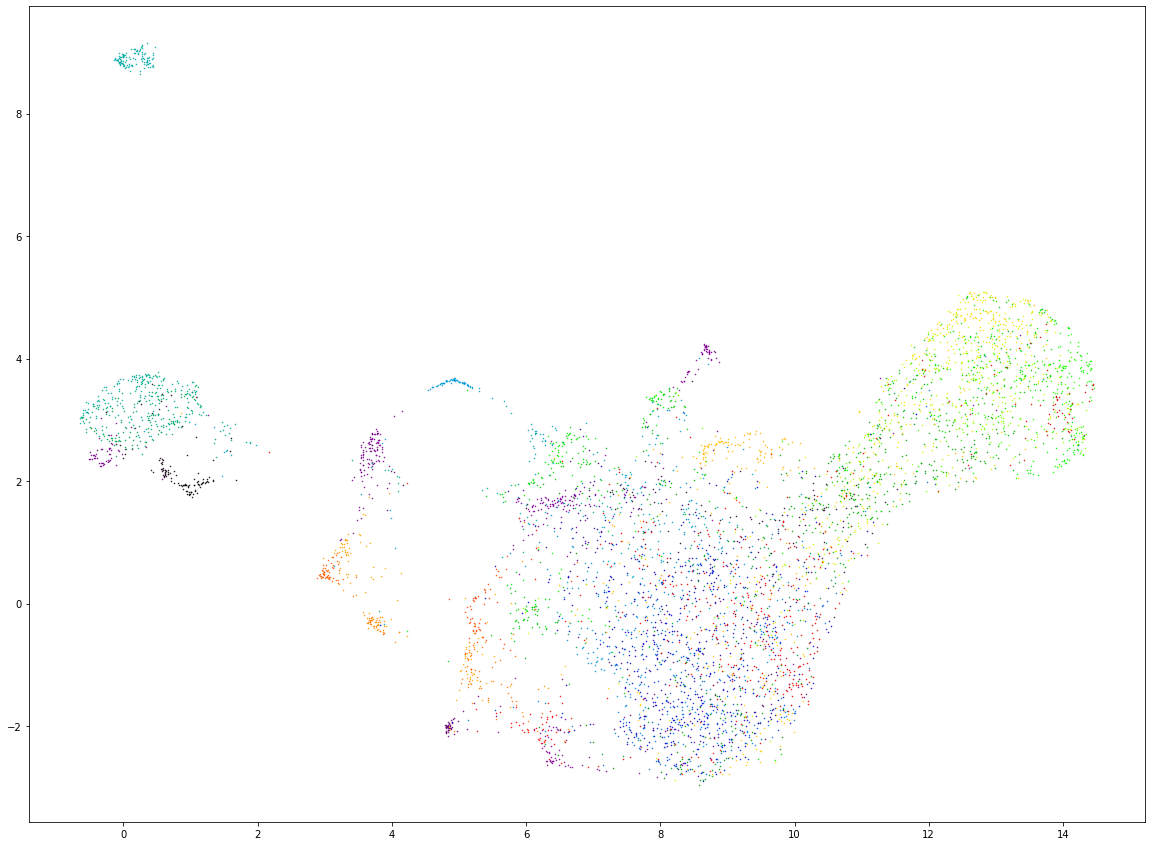

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


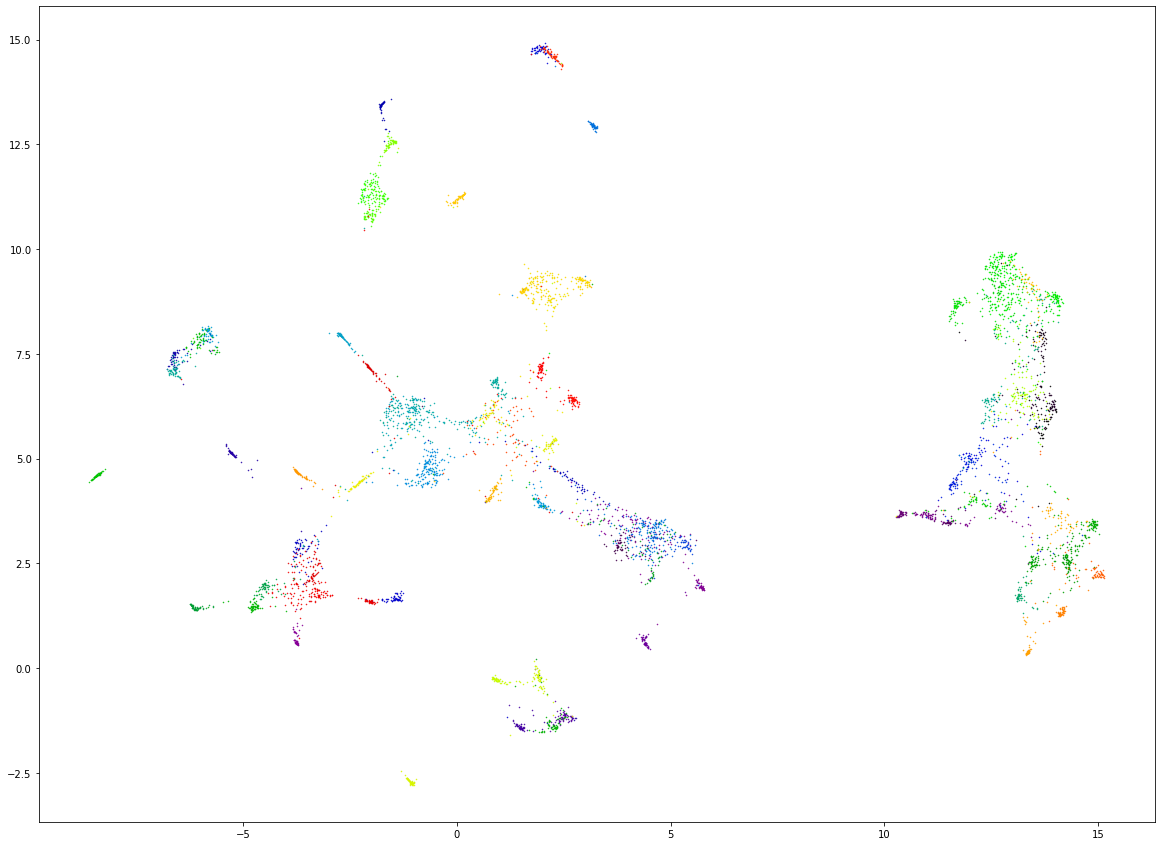

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


Sampler weights are now [0.00832987 0.00984058 0.00809742 0.00954013 0.00868002 0.0124267
 0.01025548 0.01025926 0.00608017 0.01226567 0.0073425  0.01290869
 0.01204561 0.01044135 0.01196796 0.01250127 0.01137216 0.0129666
 0.00967793 0.0098945  0.0120264  0.01120056 0.0083704  0.01069576
 0.00832987 0.01067254 0.00682505 0.01293606 0.00701266 0.00667612
 0.00962069 0.00934865 0.0081476  0.01117298 0.01039328 0.01296167
 0.00845704 0.00751329 0.0076375  0.00759595 0.01259929 0.0117379
 0.00718287 0.0104401  0.0079656  0.01184637 0.01187634 0.01339173
 0.00746092 0.00941966 0.01071718 0.01187798 0.01199218 0.00949228
 0.01233462 0.00994696 0.0136206  0.0099524  0.00624617 0.00632006
 0.01179703 0.00622481 0.01180275 0.00677992 0.00567532 0.00738284
 0.00812076 0.00811352 0.00908218 0.01257672 0.00717588 0.0073088
 0.01245974 0.01097881 0.01312873 0.01193353 0.01150094 0.00994696
 0.00999802 0.00984058 0.01190538 0.00995533 0.0128334  0.00848556
 0.0123771  0.01001474 0.01327589 0.012949

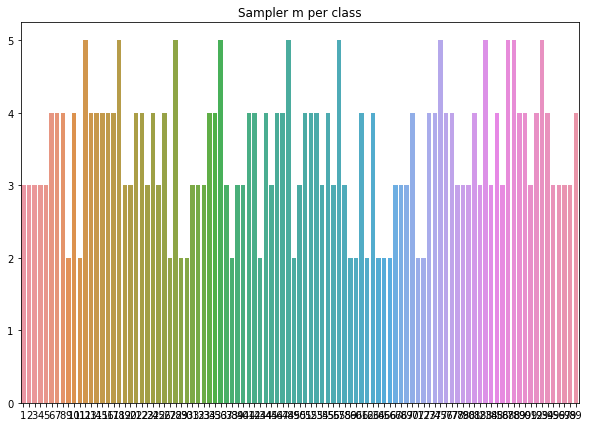

INFO:root:TRAINING EPOCH 5
total_loss=0.12350:  60%|██████    | 104/173 [00:13<00:08,  8.02it/s]

Idx list len 4774


total_loss=0.08029: 100%|██████████| 173/173 [00:22<00:00,  7.70it/s]
INFO:root:TRAINING EPOCH 6
total_loss=0.06134:  46%|████▌     | 80/173 [00:10<00:11,  7.78it/s]

Idx list len 4774


total_loss=0.10618: 100%|██████████| 173/173 [00:22<00:00,  7.66it/s]
INFO:root:Evaluating epoch 6
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:09<00:00, 18.77it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.77it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


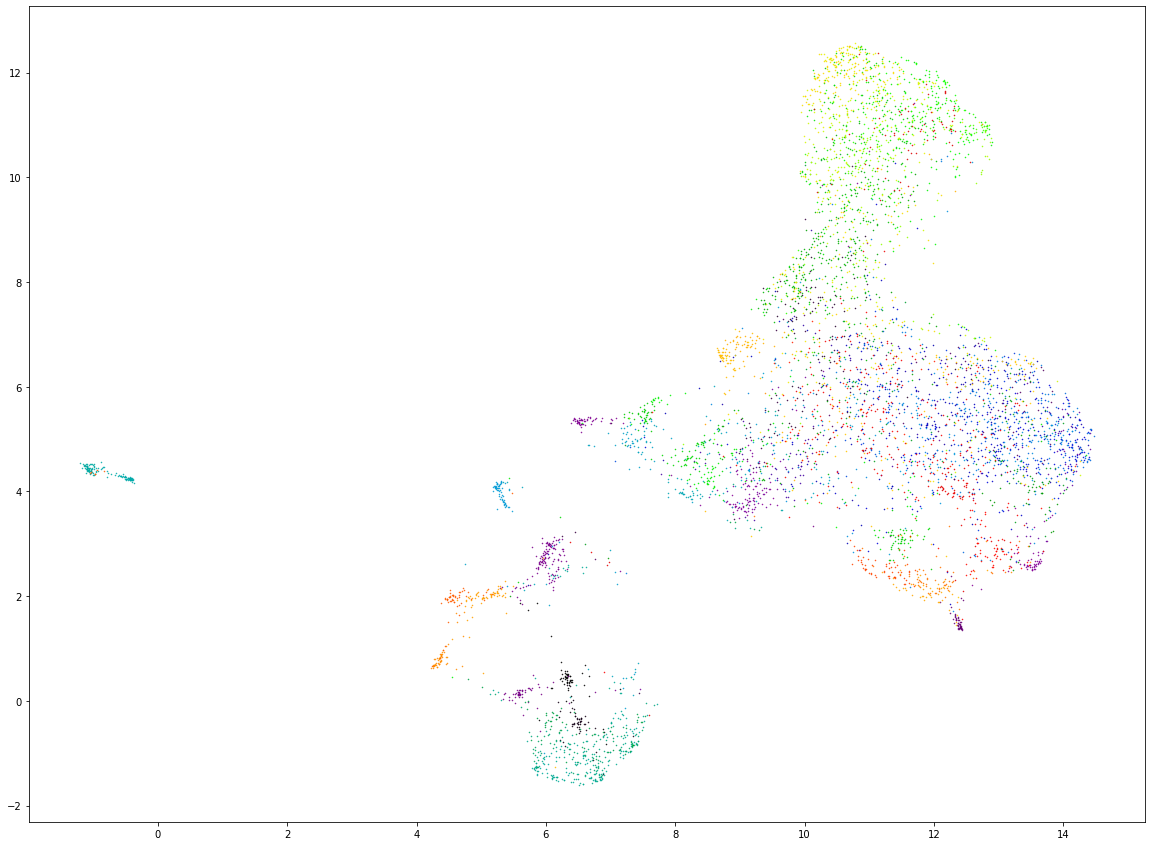

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


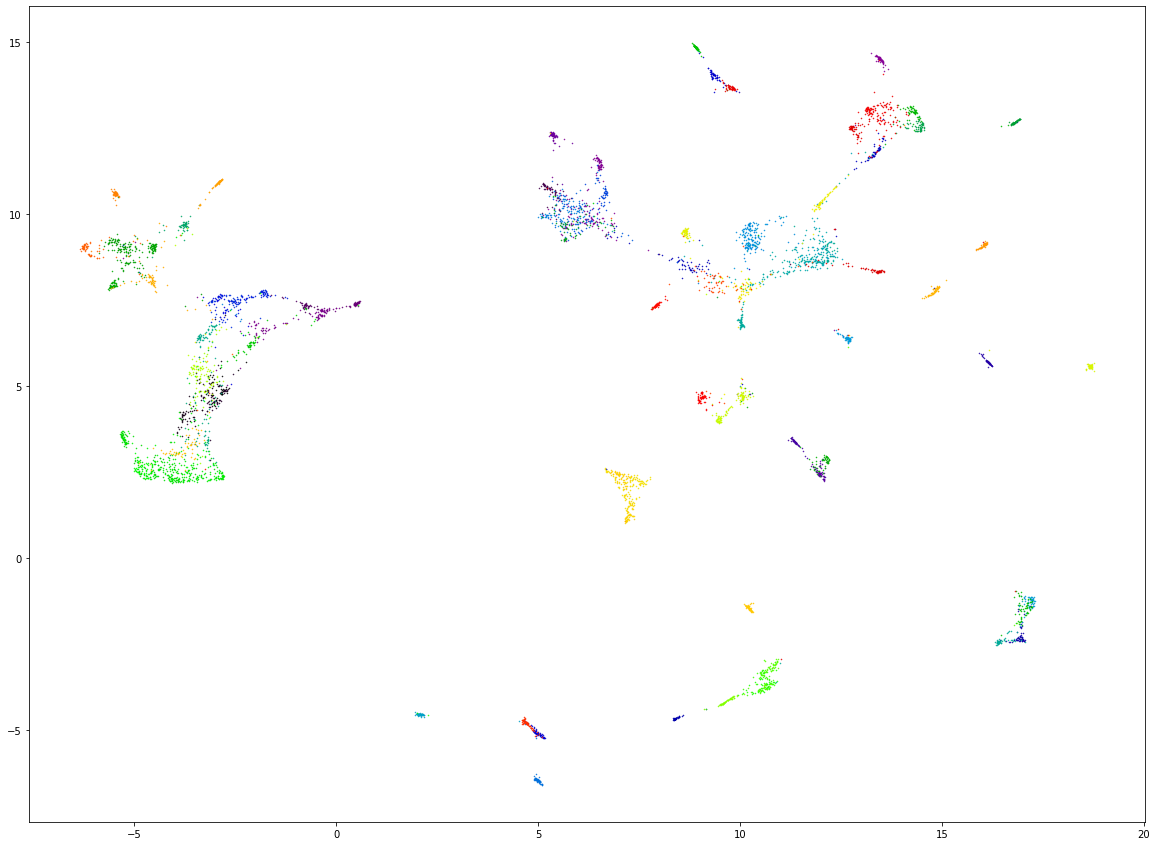

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


Sampler weights are now [0.00801112 0.0088879  0.00771169 0.00935396 0.01014911 0.01279222
 0.01183967 0.00999753 0.00584898 0.01146651 0.00799326 0.01261024
 0.01287302 0.01027055 0.01163012 0.01283541 0.01106153 0.01253186
 0.01025908 0.01087839 0.01189081 0.01075335 0.00826959 0.01065135
 0.00835426 0.01033929 0.0060197  0.01307065 0.00696018 0.00626997
 0.00800709 0.01026899 0.00771282 0.01221224 0.01009361 0.01308756
 0.00783924 0.00686703 0.00676168 0.00813728 0.01296894 0.01140512
 0.00651582 0.01141771 0.00776975 0.01217166 0.01234341 0.01308756
 0.00655212 0.00838764 0.00934752 0.01123503 0.01129141 0.00905755
 0.01193875 0.00945013 0.01308756 0.01037935 0.00612441 0.00633732
 0.01187582 0.00611074 0.01134136 0.00588199 0.00613079 0.00820425
 0.0097788  0.00842277 0.00972516 0.01186246 0.00721831 0.0078847
 0.01215931 0.01171491 0.01307065 0.01276179 0.01119373 0.00951996
 0.00934075 0.00880191 0.0115519  0.00983661 0.01308756 0.00990346
 0.01298337 0.01047082 0.01277226 0.013

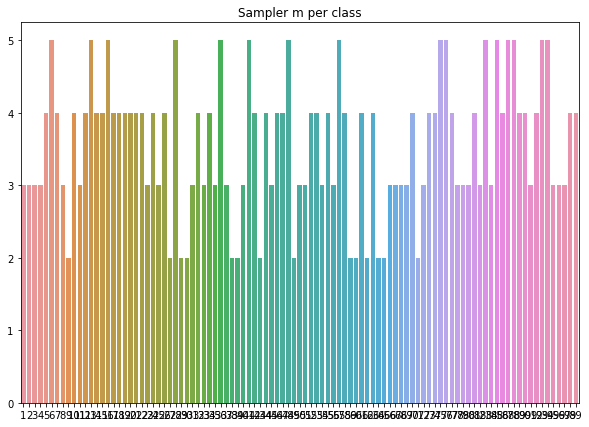

INFO:root:New best accuracy! 0.11606627413684856
INFO:root:TRAINING EPOCH 7
total_loss=0.14566:  32%|███▏      | 56/173 [00:07<00:14,  7.99it/s]

Idx list len 4928


total_loss=0.12255: 100%|██████████| 173/173 [00:22<00:00,  7.64it/s]
INFO:root:TRAINING EPOCH 8
total_loss=0.09450:  21%|██▏       | 37/173 [00:04<00:17,  7.73it/s]

Idx list len 4928


total_loss=0.08809: 100%|██████████| 173/173 [00:23<00:00,  7.51it/s]
INFO:root:Evaluating epoch 8
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 18.45it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.39it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


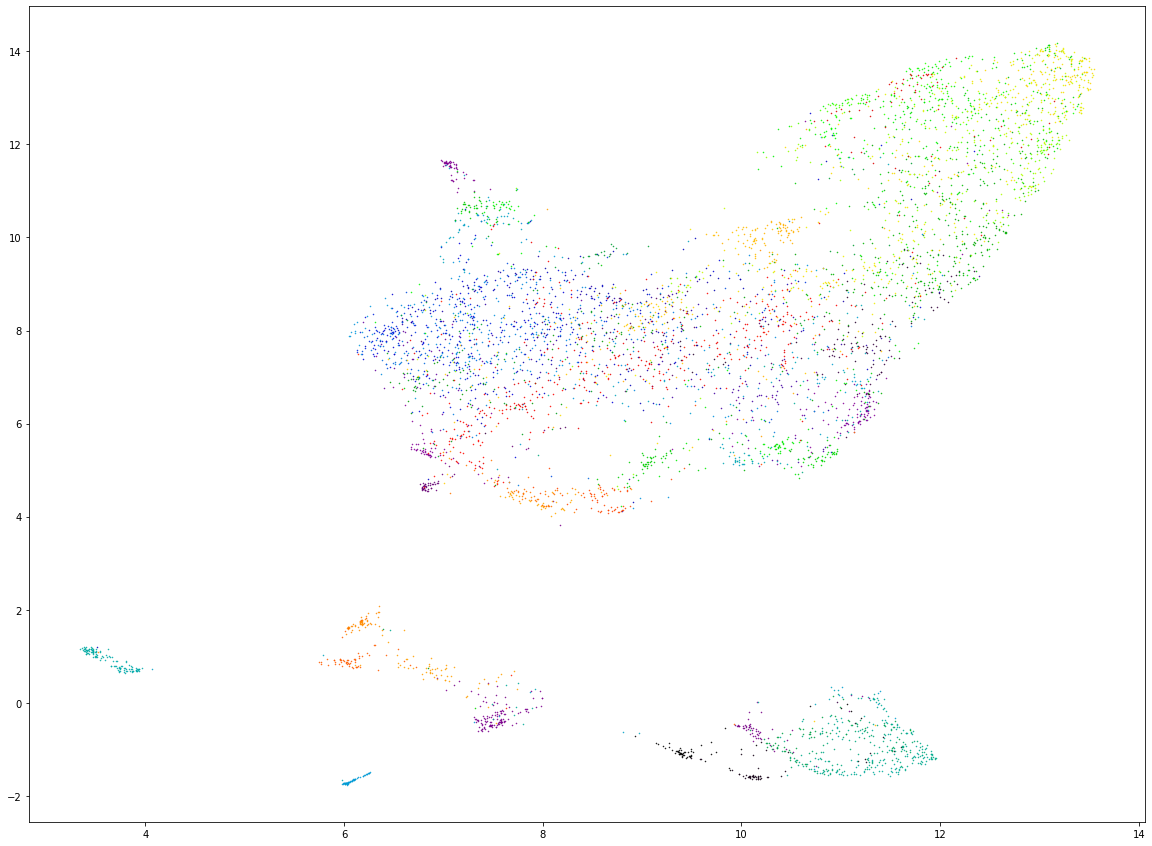

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


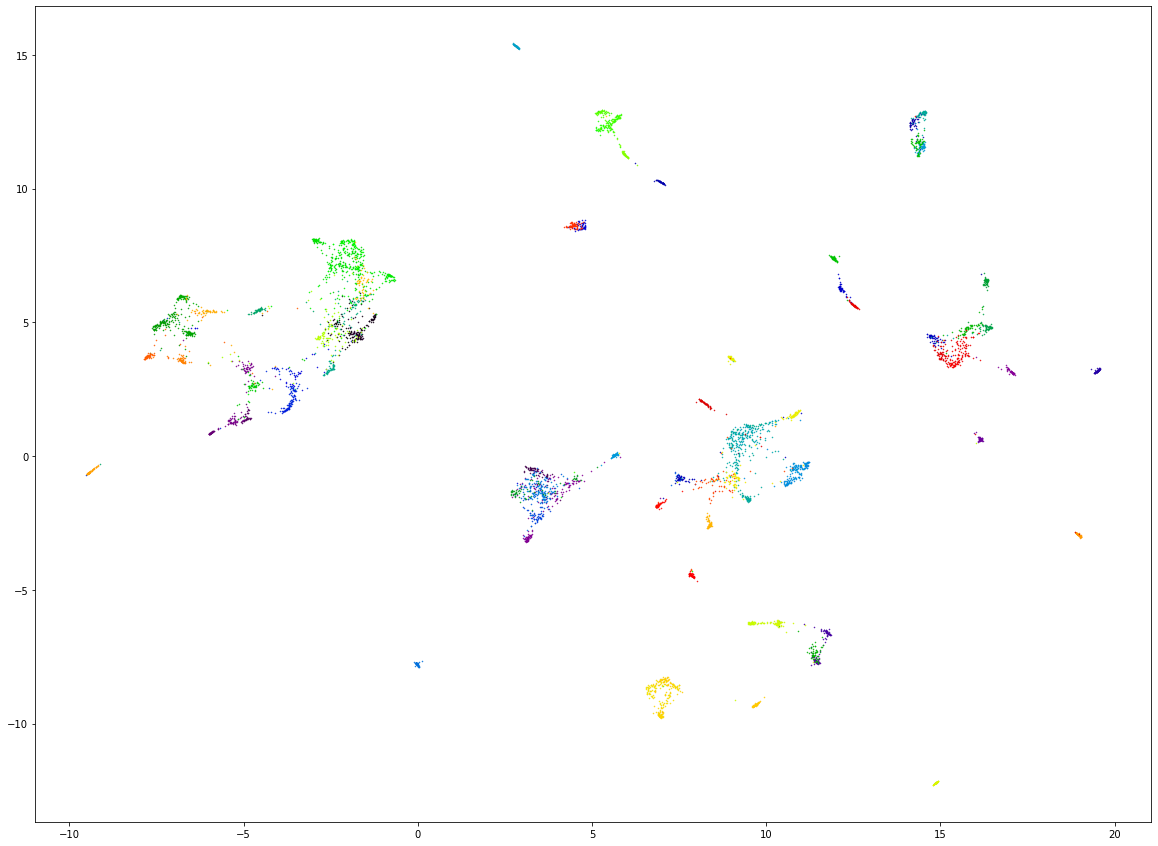

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


Sampler weights are now [0.00882072 0.00832464 0.00818651 0.01034243 0.01056584 0.01302187
 0.01041643 0.0114252  0.00579443 0.01194506 0.00772683 0.01282191
 0.0127546  0.01036432 0.0122039  0.0130656  0.01047845 0.0127523
 0.01107982 0.01043688 0.01252631 0.00998317 0.00835231 0.01083105
 0.00777883 0.01068237 0.00564755 0.01284607 0.00698495 0.00689419
 0.00919517 0.01087396 0.0079939  0.01245059 0.01034243 0.01296187
 0.00753876 0.00713237 0.00650296 0.00823251 0.01153453 0.01137181
 0.00625402 0.01103707 0.00820706 0.01205221 0.01166657 0.0128516
 0.00850946 0.00813793 0.00870628 0.0121425  0.01203441 0.0089845
 0.01093192 0.0095027  0.01307124 0.01090284 0.00589321 0.00606587
 0.01089818 0.00600723 0.01164308 0.00689317 0.00634059 0.00681935
 0.00929136 0.00867006 0.01022097 0.01215856 0.00661512 0.0076729
 0.01179373 0.01104754 0.0130656  0.01232971 0.011608   0.0093078
 0.00949811 0.00964731 0.01166657 0.00965769 0.0126462  0.00950622
 0.01296541 0.01046367 0.01296541 0.0127546

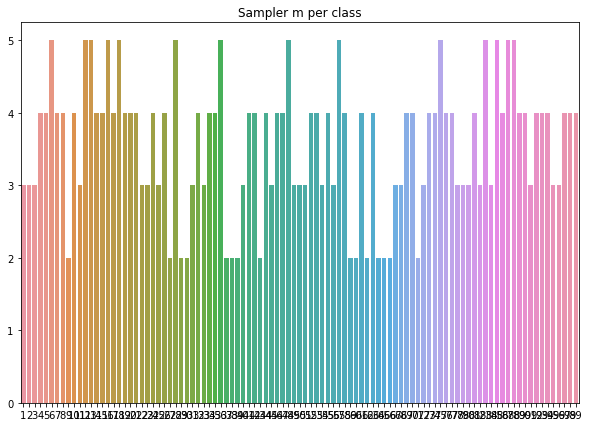

INFO:root:TRAINING EPOCH 9
total_loss=0.09564:  10%|█         | 18/173 [00:02<00:19,  7.99it/s]

Idx list len 4942


total_loss=0.07280:  99%|█████████▉| 172/173 [00:22<00:00,  7.93it/s]

Idx list len 4942


total_loss=0.09096: 100%|██████████| 173/173 [00:22<00:00,  7.60it/s]
INFO:root:TRAINING EPOCH 10
total_loss=0.09032:  88%|████████▊ | 153/173 [00:19<00:02,  8.01it/s]

Idx list len 4942


total_loss=0.07447: 100%|██████████| 173/173 [00:22<00:00,  7.75it/s]
INFO:root:Evaluating epoch 10
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 18.00it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.73it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


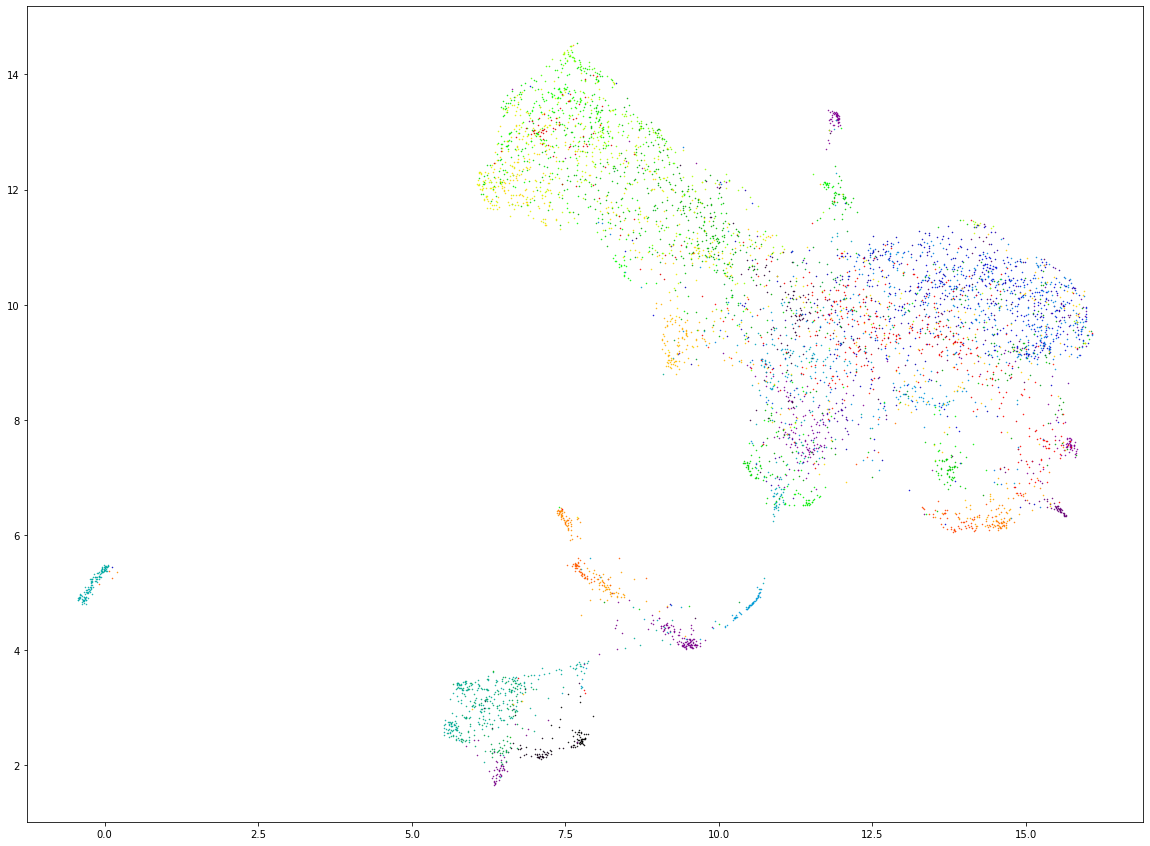

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


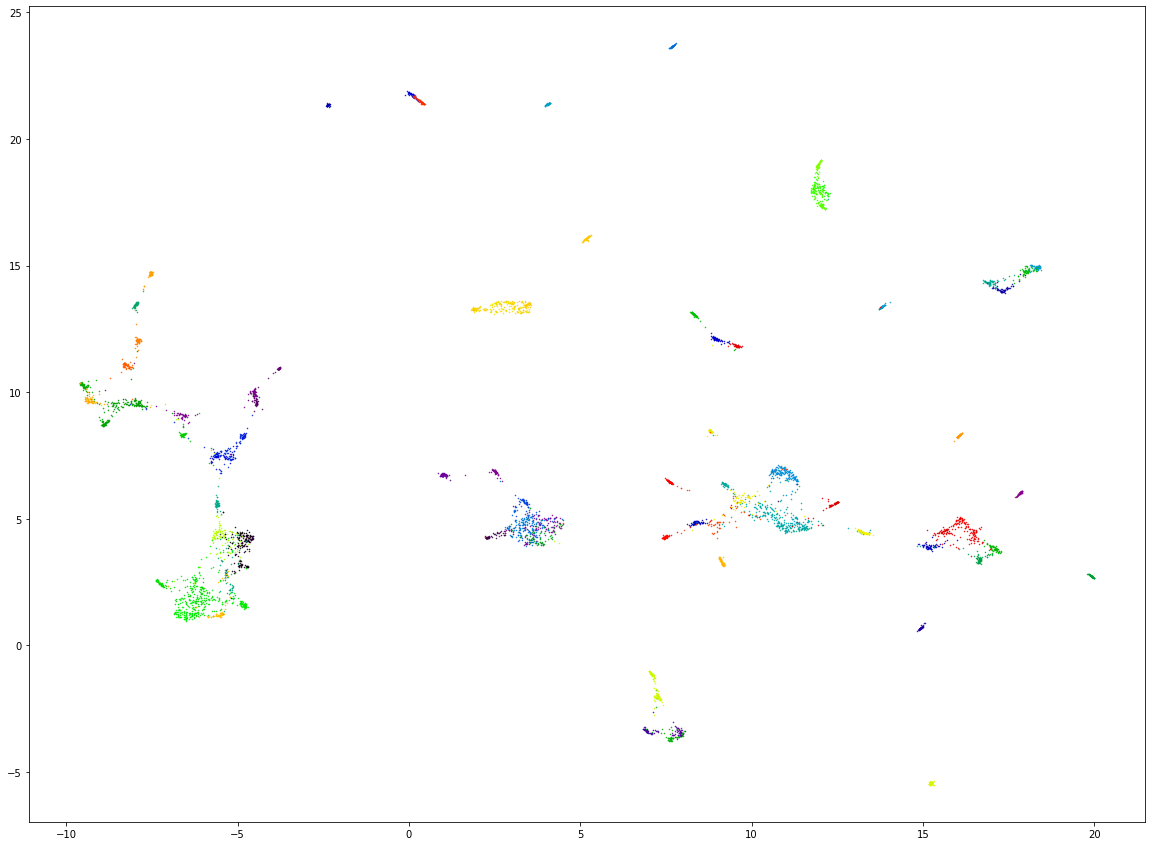

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


Sampler weights are now [0.00787104 0.00918762 0.00822939 0.01121589 0.01049806 0.01250577
 0.01053931 0.01041094 0.00687181 0.01250314 0.00789835 0.01249218
 0.01261042 0.01014332 0.01106032 0.01271134 0.01100156 0.01282236
 0.0107591  0.01143222 0.01188836 0.010134   0.00879463 0.01144992
 0.00774399 0.01059852 0.00614658 0.01282236 0.00645748 0.00546701
 0.00884002 0.01013918 0.00815147 0.01240199 0.01077939 0.01282236
 0.00712699 0.00690429 0.00639985 0.00845925 0.01147395 0.01095905
 0.00672835 0.012113   0.00765658 0.01167177 0.01202123 0.01250314
 0.00675691 0.0075043  0.0092356  0.01190323 0.01151617 0.00902784
 0.01172542 0.01025792 0.01261042 0.01134053 0.00615223 0.00616598
 0.01174221 0.00608445 0.01124634 0.00703706 0.00634385 0.00719269
 0.00898232 0.00870417 0.01016744 0.01167489 0.00717459 0.00755174
 0.0123033  0.01135024 0.01282236 0.01200852 0.01124634 0.00965868
 0.00950716 0.00928942 0.01139392 0.00968413 0.0123033  0.00991499
 0.01271682 0.01035547 0.01261042 0.01

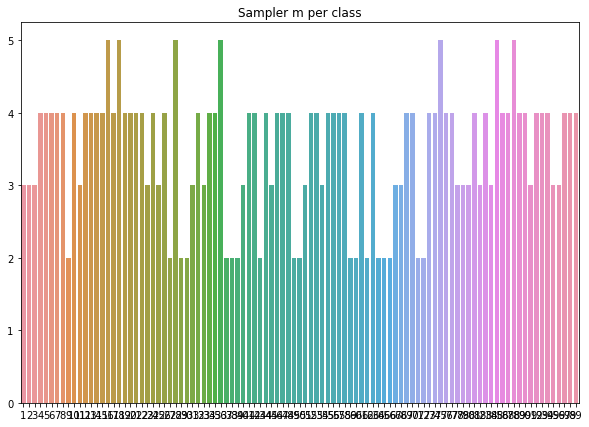

INFO:root:New best accuracy! 0.12020890014324652
INFO:root:TRAINING EPOCH 11
total_loss=0.10322:  77%|███████▋  | 134/173 [00:17<00:04,  7.99it/s]

Idx list len 4830


total_loss=0.07396: 100%|██████████| 173/173 [00:22<00:00,  7.70it/s]
INFO:root:TRAINING EPOCH 12
total_loss=0.15272:  64%|██████▍   | 111/173 [00:14<00:07,  8.03it/s]

Idx list len 4830


total_loss=0.09844: 100%|██████████| 173/173 [00:22<00:00,  7.72it/s]
INFO:root:Evaluating epoch 12
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 17.92it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.34it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


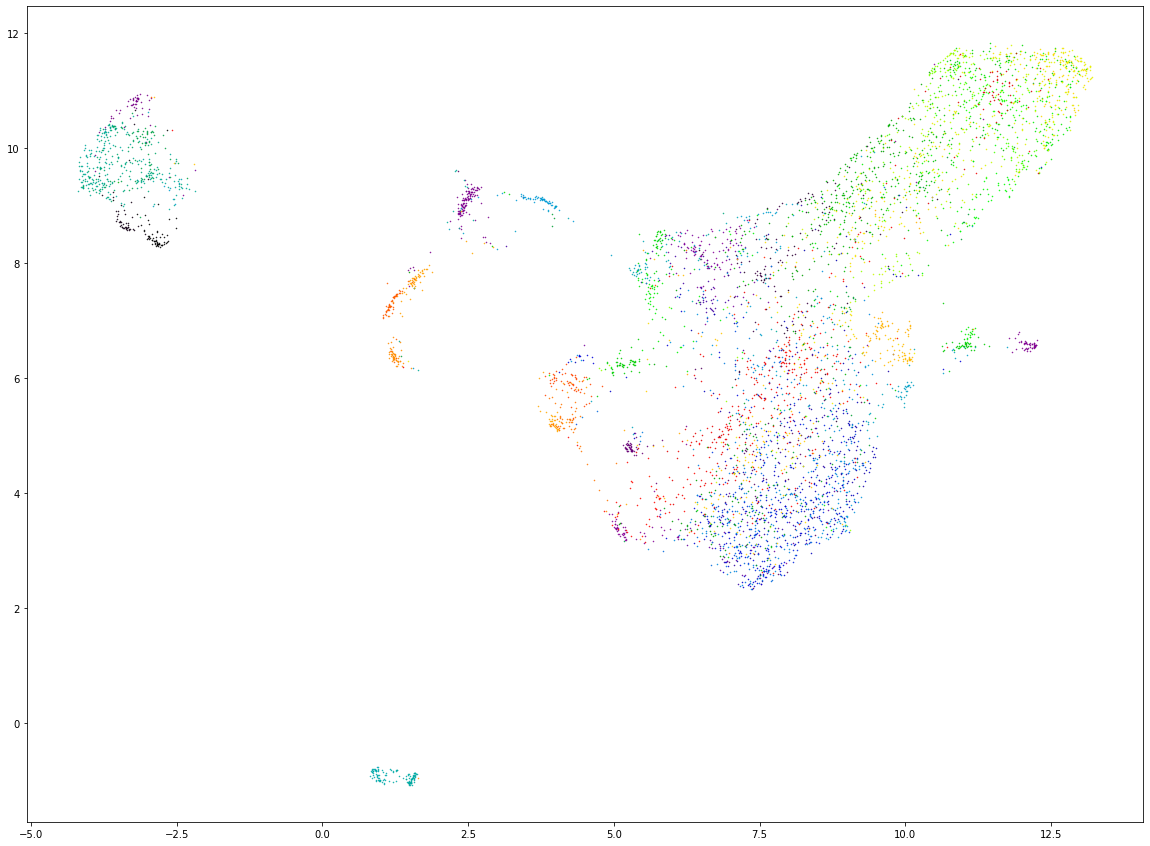

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


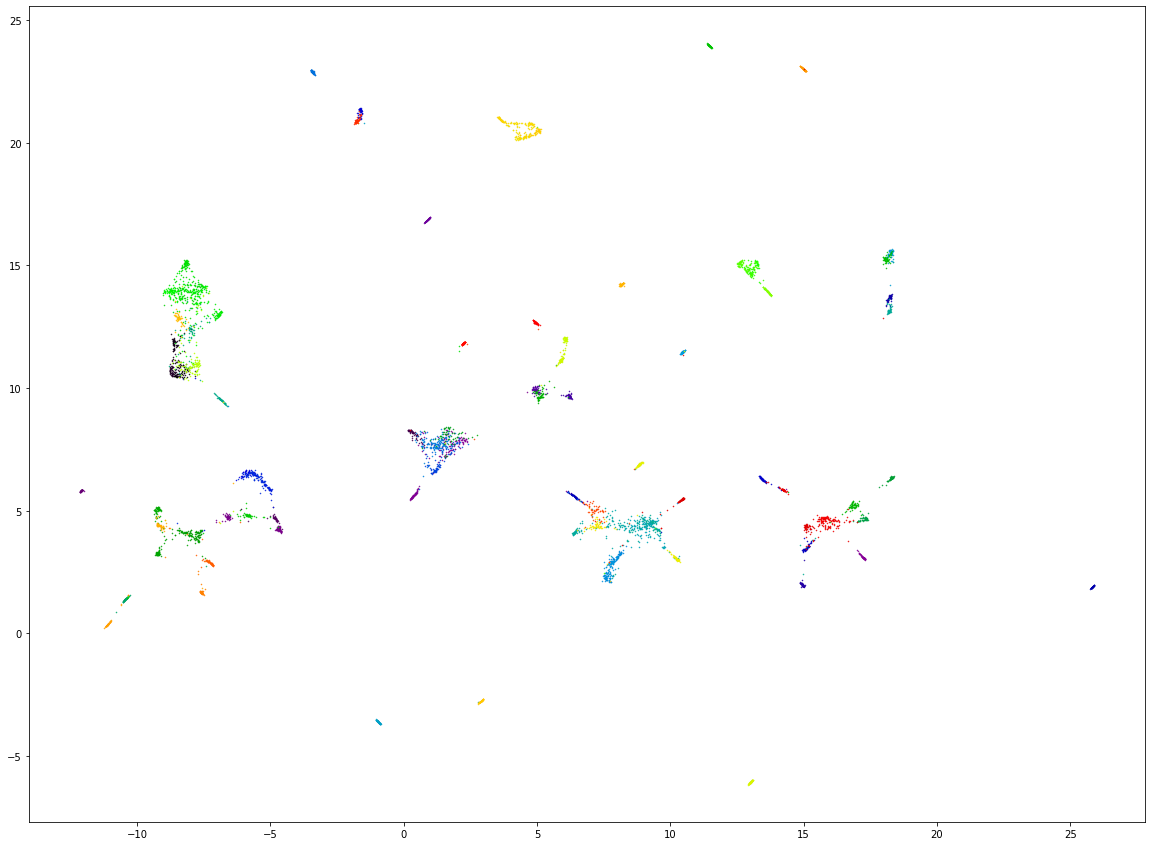

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


Sampler weights are now [0.00778976 0.00987131 0.00801036 0.01044608 0.01148111 0.01229677
 0.01161904 0.01174021 0.00689036 0.01181312 0.00846125 0.01227592
 0.01249493 0.01067999 0.01185627 0.01227592 0.01154217 0.01260038
 0.01115375 0.01074094 0.0121804  0.01089465 0.00757577 0.01066599
 0.00726978 0.01062272 0.00634178 0.01260038 0.00720009 0.00654404
 0.008935   0.01020336 0.00882161 0.01228669 0.0099307  0.01260038
 0.00776287 0.00718375 0.00684219 0.00753202 0.01127531 0.01168255
 0.00682288 0.01209031 0.00764251 0.01152243 0.01182522 0.01228669
 0.0072428  0.00873257 0.00941579 0.01208192 0.01208192 0.01000372
 0.01169716 0.00965098 0.01260038 0.01127531 0.00578894 0.00567124
 0.01137439 0.00567124 0.01089785 0.00728561 0.00500119 0.00652206
 0.00848898 0.00814846 0.01035164 0.01182522 0.00666829 0.00764251
 0.01208192 0.01177443 0.01249128 0.01209031 0.01209844 0.00877281
 0.00924416 0.00934257 0.01099815 0.0096353  0.0123955  0.01008959
 0.0123955  0.01089635 0.01228669 0.01

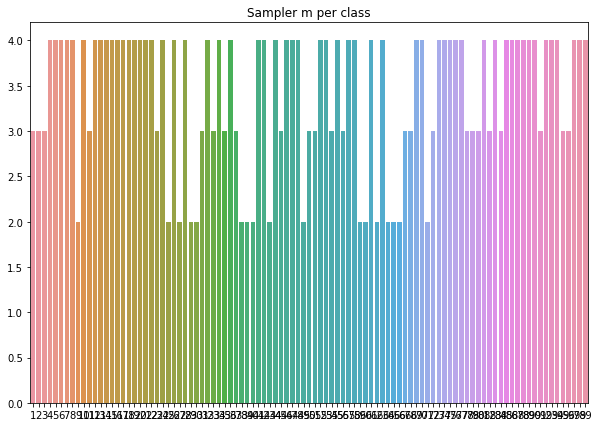

INFO:root:New best accuracy! 0.12505077509082677
INFO:root:TRAINING EPOCH 13
total_loss=0.07350:  51%|█████     | 88/173 [00:11<00:10,  7.73it/s]

Idx list len 4718


total_loss=0.11351: 100%|██████████| 173/173 [00:23<00:00,  7.49it/s]
INFO:root:TRAINING EPOCH 14
total_loss=0.08214:  36%|███▌      | 62/173 [00:08<00:14,  7.76it/s]

Idx list len 4718


total_loss=0.12533: 100%|██████████| 173/173 [00:23<00:00,  7.44it/s]
INFO:root:Evaluating epoch 14
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 17.97it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:10<00:00, 18.02it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


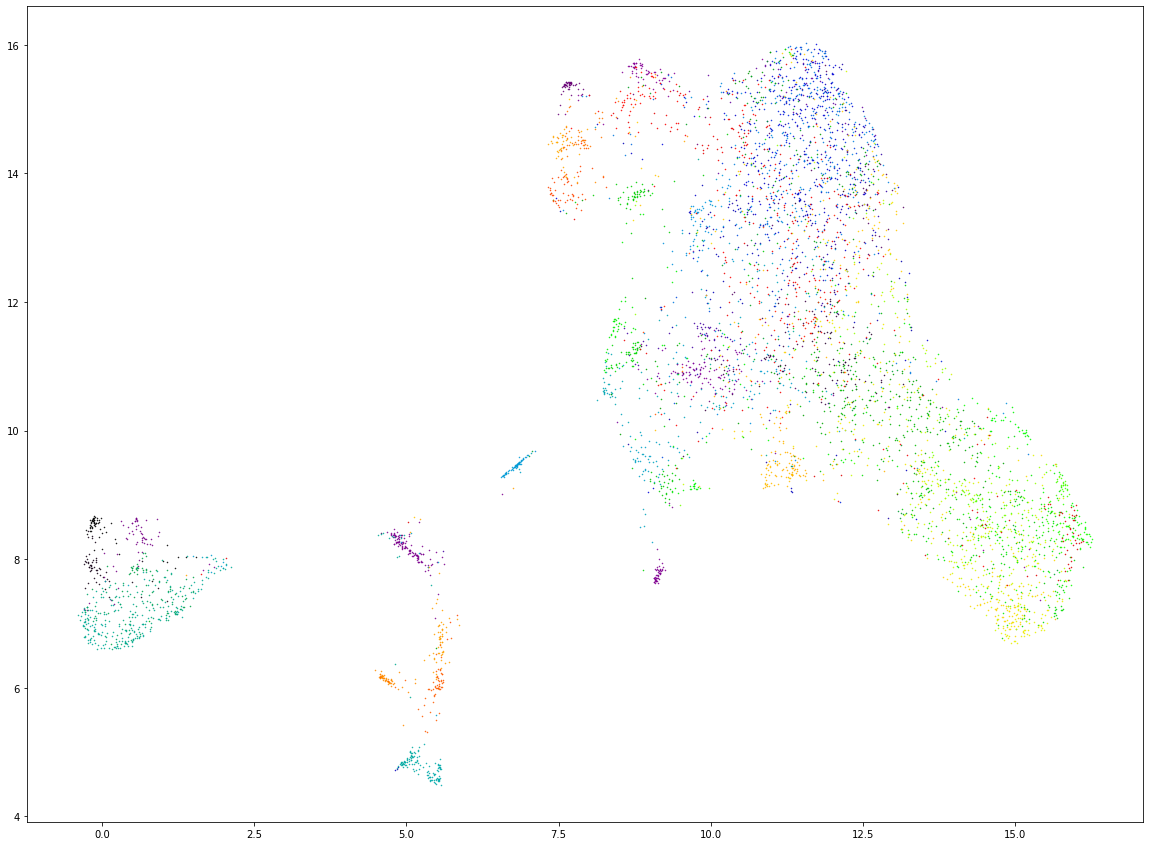

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


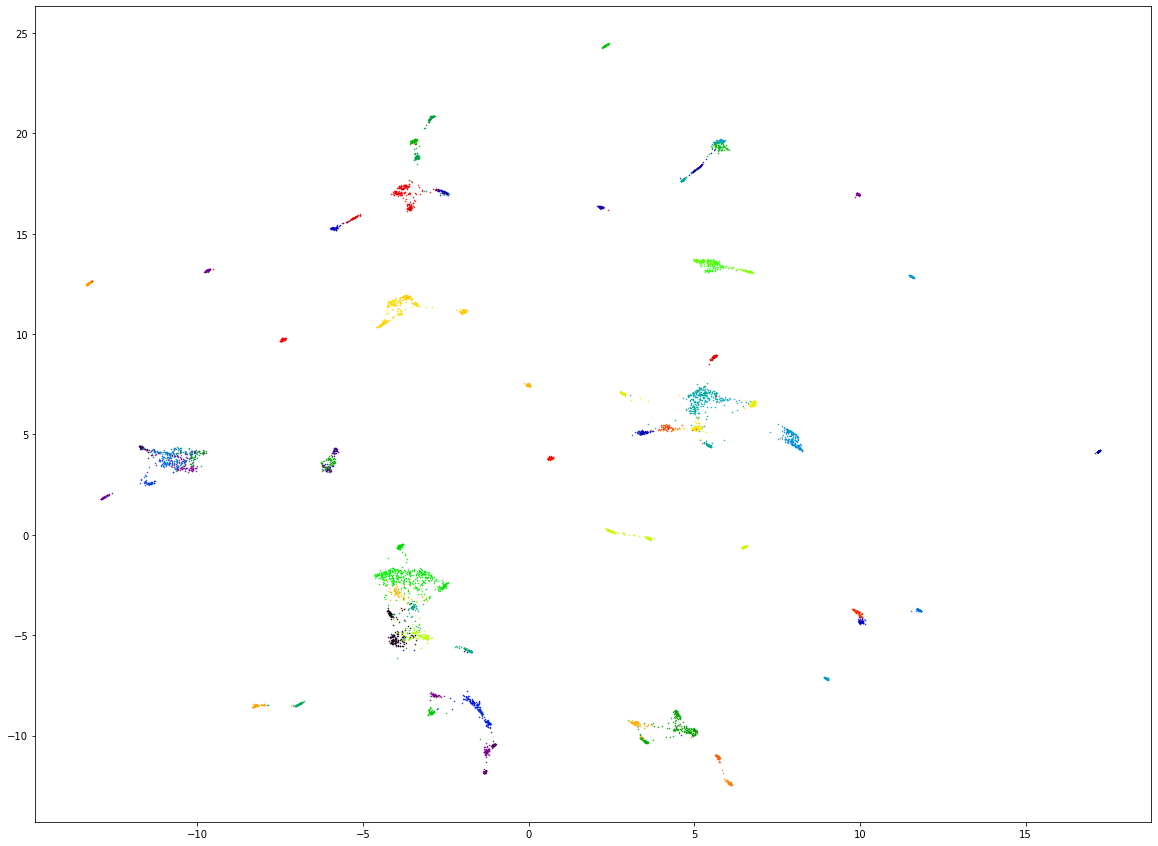

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


Sampler weights are now [0.00793019 0.00871095 0.00746975 0.01036931 0.01070303 0.01227552
 0.01103074 0.01217177 0.00638075 0.01182188 0.00795983 0.012428
 0.01211339 0.01039846 0.01090823 0.01210799 0.01116529 0.012428
 0.01108063 0.01114039 0.01202057 0.01091702 0.00819909 0.01077356
 0.00822562 0.01085211 0.00608403 0.012428   0.00677605 0.00636127
 0.00944758 0.01090823 0.00833074 0.01211861 0.00995157 0.01222259
 0.00798921 0.00722174 0.00729869 0.01006378 0.01193293 0.01171803
 0.00656569 0.01175117 0.00821662 0.01162649 0.01162649 0.01222259
 0.0077196  0.0083455  0.00919229 0.01192492 0.01162649 0.00955242
 0.01222593 0.00927061 0.012428   0.01177974 0.00530533 0.00578487
 0.0116392  0.00647816 0.01141218 0.00697248 0.00588918 0.00611062
 0.00875019 0.00828953 0.0091602  0.01166345 0.0065071  0.00796116
 0.01211861 0.01192492 0.0123204  0.01211339 0.01167503 0.01030841
 0.00941818 0.00923181 0.011299   0.00910184 0.01222593 0.00963161
 0.01212366 0.01092354 0.01202057 0.012325

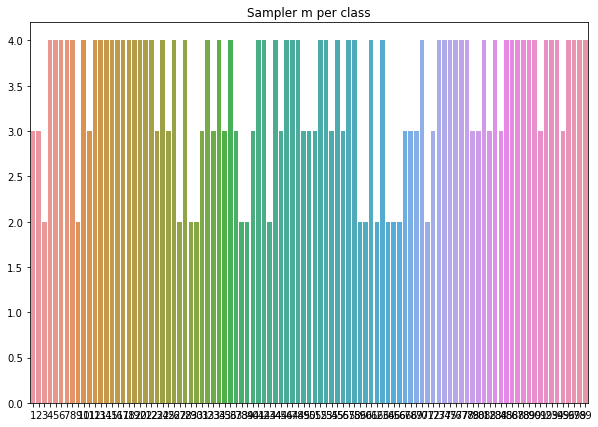

INFO:root:TRAINING EPOCH 15
total_loss=0.06852:  21%|██        | 36/173 [00:04<00:17,  7.75it/s]

Idx list len 4760


total_loss=0.12259: 100%|██████████| 173/173 [00:22<00:00,  7.54it/s]
INFO:root:TRAINING EPOCH 16
total_loss=0.10624:   6%|▋         | 11/173 [00:01<00:20,  7.79it/s]

Idx list len 4760


total_loss=0.01456:  92%|█████████▏| 159/173 [00:21<00:01,  7.75it/s]

Idx list len 4760


total_loss=0.12061: 100%|██████████| 173/173 [00:23<00:00,  7.28it/s]
INFO:root:Evaluating epoch 16
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 17.56it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:10<00:00, 17.84it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


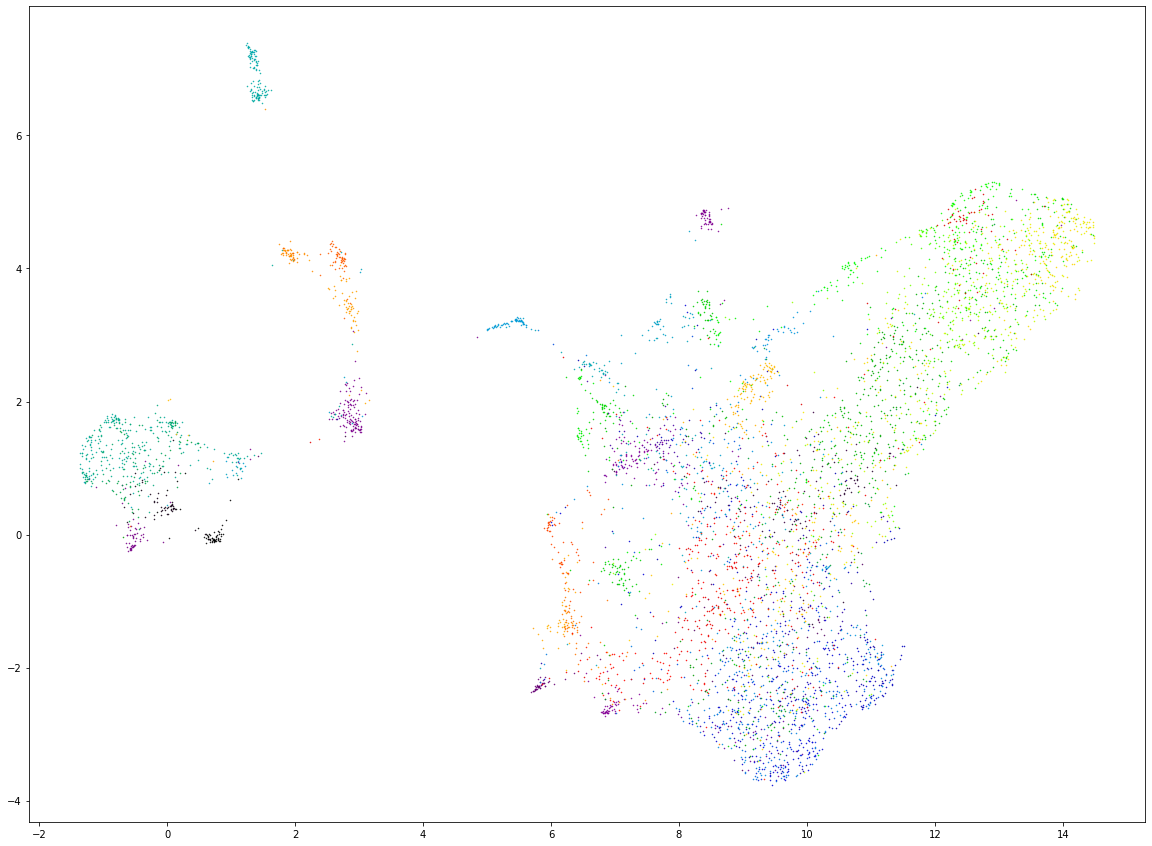

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


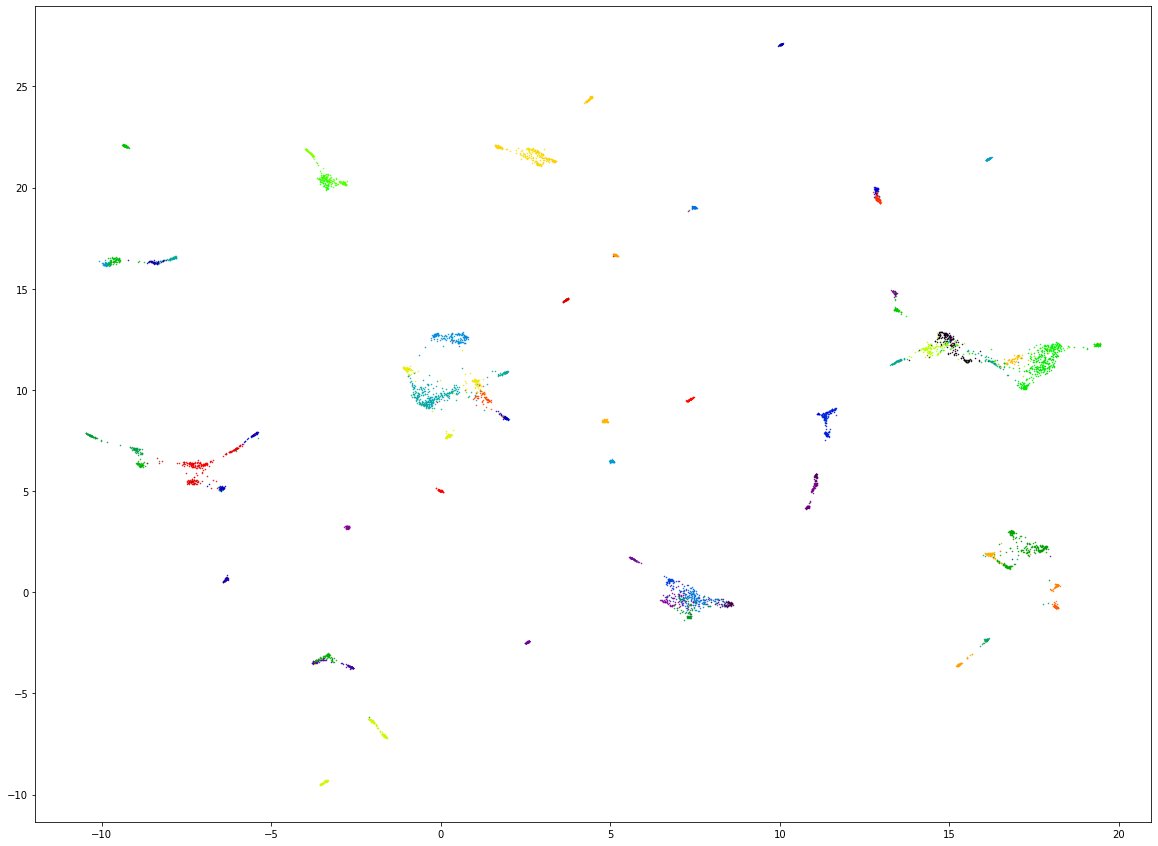

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


Sampler weights are now [0.00792761 0.00944414 0.00781314 0.01064607 0.01160607 0.01200535
 0.01155697 0.01148504 0.00571158 0.01189899 0.00826576 0.01220081
 0.01230926 0.01069447 0.01148896 0.01220269 0.01086289 0.01230926
 0.0116283  0.01145415 0.01189899 0.01035299 0.00868108 0.01159243
 0.00817971 0.01052052 0.00601157 0.0122045  0.0068196  0.00633666
 0.00919825 0.0112396  0.00840254 0.01210581 0.00968601 0.01220626
 0.00734649 0.00783832 0.006266   0.00956565 0.01160607 0.01141264
 0.00622211 0.01181892 0.00923989 0.01169901 0.01171853 0.01220626
 0.00775368 0.00896456 0.00908642 0.01171853 0.01089606 0.00993502
 0.01180278 0.00962583 0.01230926 0.01156988 0.00553091 0.00590605
 0.01117387 0.00594814 0.01135555 0.00729666 0.00617109 0.00662279
 0.00944414 0.00872639 0.0099114  0.01200282 0.0059938  0.00825115
 0.01122244 0.01105535 0.01220269 0.01200282 0.01119105 0.00938426
 0.00964707 0.00919184 0.01145415 0.00921743 0.01230926 0.00981525
 0.01220795 0.01099509 0.01210581 0.01

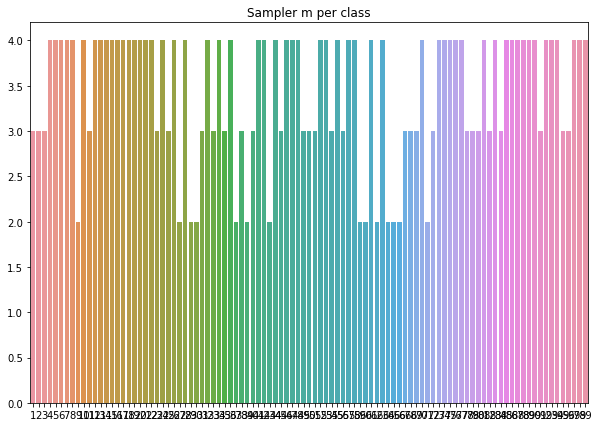

INFO:root:Validation accuracy has plateaued. Exiting.


In [25]:
end_of_epoch_hook, end_of_iteration_hook = get_testing_hooks(experiment_id, val_dataset, params.test_interval, params.patience)
trainer = trainers.MetricLossOnly(models,
                                optimizers,
                                params.batch_size,
                                loss_funcs,
                                mining_funcs,
                                train_dataset,
                                sampler=sampler,
                                dataloader_num_workers = 4,
                                end_of_iteration_hook = end_of_iteration_hook,
                                end_of_epoch_hook = end_of_epoch_hook)

trainer.train(num_epochs=params.num_epochs)

In [26]:
torch.save(embedder.state_dict(), os.path.join(experiment_dir, 'embedder.pt'))
torch.save(trunk.state_dict(), os.path.join(experiment_dir, 'trunk.pt'))

In [27]:
print('Best models')
best_embedder, best_trunk = [os.path.join(experiment_dir, fname) for fname in os.listdir(experiment_dir) if 'embedder_best' in fname][0], [os.path.join(experiment_dir, fname) for fname in os.listdir(experiment_dir) if 'trunk_best' in fname][0]

best_embedder, best_trunk

Best models


('experiment_logs/09-10_14:27_weighted_sampler/embedder_best12.pth',
 'experiment_logs/09-10_14:27_weighted_sampler/trunk_best12.pth')

In [28]:
trunk, trunk_output_size = get_trunk(device)
trunk.load_state_dict(torch.load(best_trunk))
trunk = trunk.to(device)

embedder = get_embedder(trunk_output_size, params.embedder_layers, device)
embedder.load_state_dict(torch.load(best_embedder))
embedder = embedder.to(device)

# Evaluate results

In [29]:
gallery_dataset = original_train
query_dataset = original_val
gallery_dataset.transform = val_transform
query_dataset.transform = val_transform

gallery_labels = np.array([gallery_dataset.target(i) for i in range(len(gallery_dataset))])
query_labels = np.array([query_dataset.target(i) for i in range(len(query_dataset))])

In [30]:
inference_model = get_inference_model(trunk, embedder)

In [31]:
gallery_embeddings = get_embeddings(inference_model, gallery_dataset)
query_embeddings = get_embeddings(inference_model, query_dataset)

100%|██████████| 5794/5794 [00:35<00:00, 161.60it/s]


In [32]:
get_scores(inference_model, gallery_embeddings, query_embeddings, gallery_labels, query_labels)

INFO:root:running k-nn with k=30
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=200
INFO:root:embedding dimensionality is 256


{'AMI': 0.5346463337381817,
 'NMI': 0.7067820072951222,
 'mean_average_precision_at_r': 0.23915726686757222,
 'precision_at_1': 0.48688298239558164,
 'r_precision': 0.3394117577041648}

## Visual evaluation

In [33]:
inv_normalize = get_inverse_transform()

def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize = figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataset = val_dataset

In [34]:
class_a = dataset.targets[0]
class_b = dataset.targets[100]

class_a_idx = (dataset.targets == class_a).nonzero()[0]
class_b_idx = (dataset.targets == class_b).nonzero()[0]

In [35]:
class_a_idx[:10], class_b_idx[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

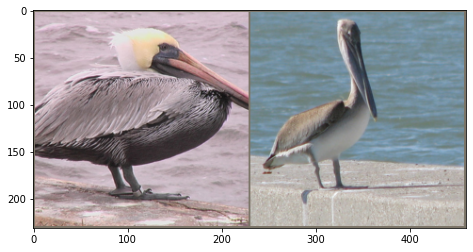

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [36]:
# compare two images of the same class
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_a_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

In [ ]:
# compare two images of different classes
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_b_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

In [ ]:
# compare two random images
idx1 = np.random.choice(range(len(dataset)))
idx2 = np.random.choice(range(len(dataset)))
(x, x_label), (y, y_label) = dataset[idx1], dataset[idx2]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)
print('Actually same' if x_label==y_label else "Actually different")

## Retrieval

In [ ]:
inference_model.train_indexer(gallery_images, 256)

In [ ]:
k = 5
query_idx = np.random.randint(0, len(gallery_dataset))
query_img = gallery_dataset[query_idx][0]
query_batch =  [query_img]
# D, I = index.search(query_batch, k)
# print(D)

I, D = inference_model.get_nearest_neighbors(query_batch, k=k)
print(D)
neighbors_idx = I[0]
neighbors_imgs = [gallery_dataset[i][0] for i in neighbors_idx]
neighbors_labels = gallery_labels[neighbors_idx]

imshow(query_img)

imshow(torchvision.utils.make_grid(torch.stack(neighbors_imgs, dim=0)))
print('Query label', gallery_labels[query_idx])
print('Neighbor labels', neighbors_labels)

In [ ]:
import itertools
from scipy.spatial.distance import pdist, cdist
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [ ]:
same_label_distances = {}
diff_label_distances = {}

def get_label_vectors(label):
    label_indices = np.array(range(len(gallery_labels)))[gallery_labels == label]
    vectors = [gallery_embeddings[i].numpy() for i in label_indices]    
    return vectors

for label in tqdm(set(gallery_labels)):
    vectors = get_label_vectors(label)

    distances = pdist(vectors, metric='cosine')
    same_label_distances[label] = distances
    
    diff_labels = list(set(gallery_labels).difference(set([label])))
    other_label = np.random.choice(diff_labels)
    other_vectors = get_label_vectors(other_label)
    
    other_distances_matrix = cdist(vectors, other_vectors)
    other_distances = []
    # Get upper triangle of matrix
    for i in range(len(other_distances_matrix)-1):
        other_distances.append(other_distances_matrix[i][i+1:])
    other_distances = np.concatenate(other_distances)
    
    diff_label_distances[(label, other_label)] = other_distances

In [ ]:
random_indices = np.random.choice(range(len(gallery_labels)), 1000)
random_distances = pdist(gallery_embeddings[random_indices].numpy(), metric='cosine')

In [ ]:
all_same_label_dists = np.concatenate([dists for l, dists in same_label_distances.items()])
all_diff_label_distances = np.concatenate([dists for l, dists in diff_label_distances.items()])

plt.figure(figsize=(15, 7))
sns.distplot(all_same_label_dists, label='same label')
sns.distplot(all_diff_label_distances, label='different label')
sns.distplot(random_distances, label='random pairs')
plt.xlabel('Cosine')
plt.title("Distances distribution")
plt.legend()
plt.show()

In [ ]:
means = []
stds = []
for label, distances in same_label_distances.items():
    means.append(np.mean(distances))
    stds.append(np.std(distances))
    
sort_order = np.argsort(means)

labels = [label for label in same_label_distances]
sorted_labels = np.array(labels)[sort_order]

def autolabel(rects, text):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                text,
                ha='center', va='bottom')
        
fig, ax = plt.subplots(figsize=(25, 7))
width = 0.5
for i, label in enumerate(sorted_labels):
    distances = same_label_distances[label]
    rects = ax.bar(i, np.mean(distances), width, yerr=np.std(distances), align='center', alpha=0.5, ecolor='grey', capsize=5)
    autolabel(rects, f'{label}')
    
    ax.yaxis.grid(True)


plt.ylabel("Mean/std cosine dist within label")
plt.xlabel('Ranking by mean cosine dist within label, least to greatest')
# Save the figure and show
plt.title("Labels sorted by mean cosine. Some labels have bigger inter-class differences and variation")
plt.tight_layout()
plt.show()